# GeoBench BigEarthNetV2

In [11]:
import matplotlib.pyplot as plt
import json
from pathlib import Path
import numpy as np
import pandas as pd
import os

from geobench_v2.datamodules import GeoBenchBENV2DataModule
from geobench_v2.datasets import GeoBenchBENV2
from geobench_v2.datasets.data_util import MultiModalNormalizer, SatMAENormalizer
from geobench_v2.datasets.visualization_util import (
    compute_batch_histograms,
    plot_batch_histograms,
    plot_channel_histograms,
)
import tacoreader
from geobench_v2.datasets.visualization_util import (
    compute_batch_histograms,
    plot_batch_histograms,
)
import torch
import numpy as np

%load_ext autoreload
%autoreload 2

In [12]:
PROJECT_ROOT = Path("../../")

In [14]:
# band_order = {"s2": ["B04", "B03", "B02"], "s1": ["VV", "VH"]}
band_order = GeoBenchBENV2.band_default_order

datamodule = GeoBenchBENV2DataModule(
    img_size=120,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "benv2",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

PATHS ['geobench_benv2.tortilla']
Using provided pre-initialized normalizer instance: Identity
PATHS ['geobench_benv2.tortilla']
Using provided pre-initialized normalizer instance: Identity


Map extent: Longitude [-13.99° to 36.54°], Latitude [31.96° to 72.97°]
Found 3 dataset splits: train, test, validation


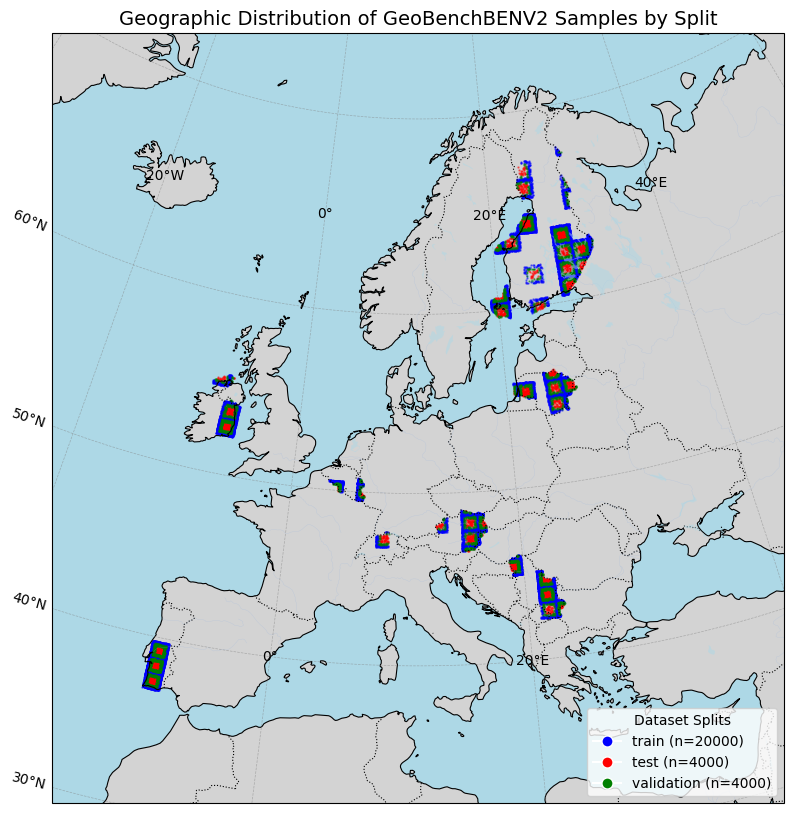

In [4]:
sample_dist_fig = datamodule.visualize_geospatial_distribution()

In [15]:
STATS_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats"
)
STATS_WITH_CLIP_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats_with_clip"
)

# Load dataset statistics from JSON files
direct_stats_path = os.path.join(STATS_DIR, "benv2", "benv2_stats.json")
satmae_stats_path = os.path.join(STATS_WITH_CLIP_DIR, "benv2", "benv2_stats.json")


def create_normalizer_from_stats(stats_path, normalizer_class, band_order):
    """Create a data normalizer from a stats JSON file."""
    with open(stats_path, "r") as f:
        stats = json.load(f)

    means = {}
    stds = {}
    clip_min = {}
    clip_max = {}

    for modality, modality_stats in stats["input_stats"].items():
        mod_name = modality.split("_")[1]
        bands = modality_stats["band_names"]
        mean_values = modality_stats["mean"]
        std_values = modality_stats["std"]

        if "clip_min_used" in modality_stats:
            clip_min[mod_name] = modality_stats["clip_min_used"]
        if "clip_max_used" in modality_stats:
            clip_max[mod_name] = modality_stats["clip_max_used"]

        for i, band in enumerate(bands):
            if i < len(mean_values) and i < len(std_values):
                means[band] = mean_values[i]
                stds[band] = std_values[i]

    norm_stats = {
        "means": means,
        "stds": stds,
        "clip_min": clip_min,
        "clip_max": clip_max,
    }

    # Create normalizer instance
    if normalizer_class == SatMAENormalizer:
        return normalizer_class(norm_stats, band_order, output_range="zero_one")
    else:
        return normalizer_class(norm_stats, band_order)


multimodal_normalizer = create_normalizer_from_stats(
    direct_stats_path, MultiModalNormalizer, band_order
)
satmae_normalizer = create_normalizer_from_stats(
    satmae_stats_path, SatMAENormalizer, band_order
)

### Raw Image Statistics

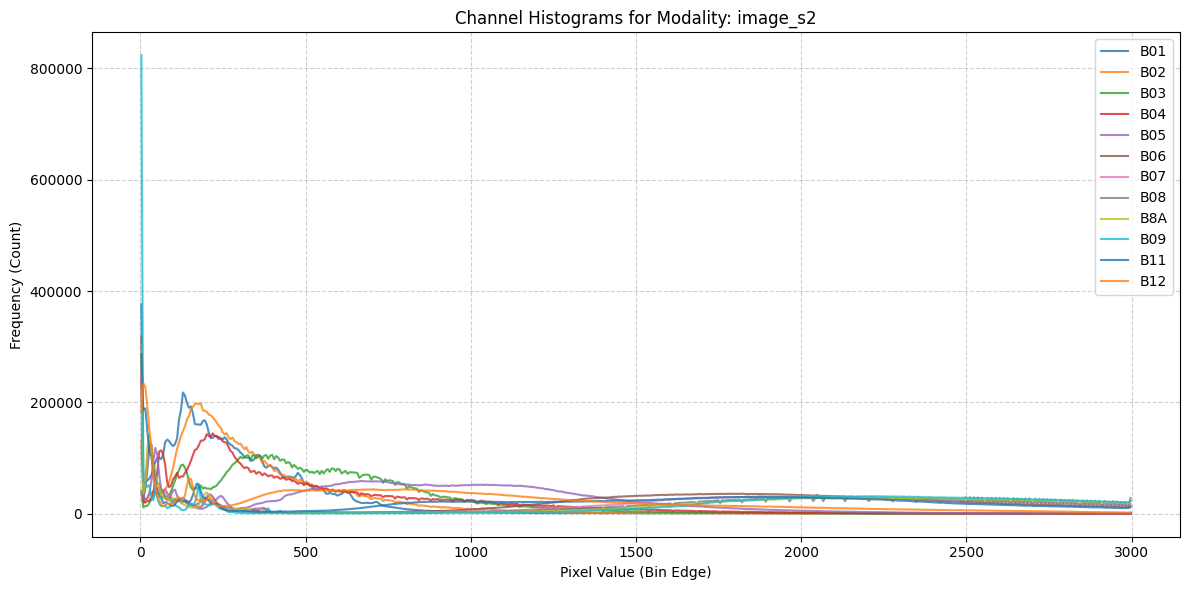

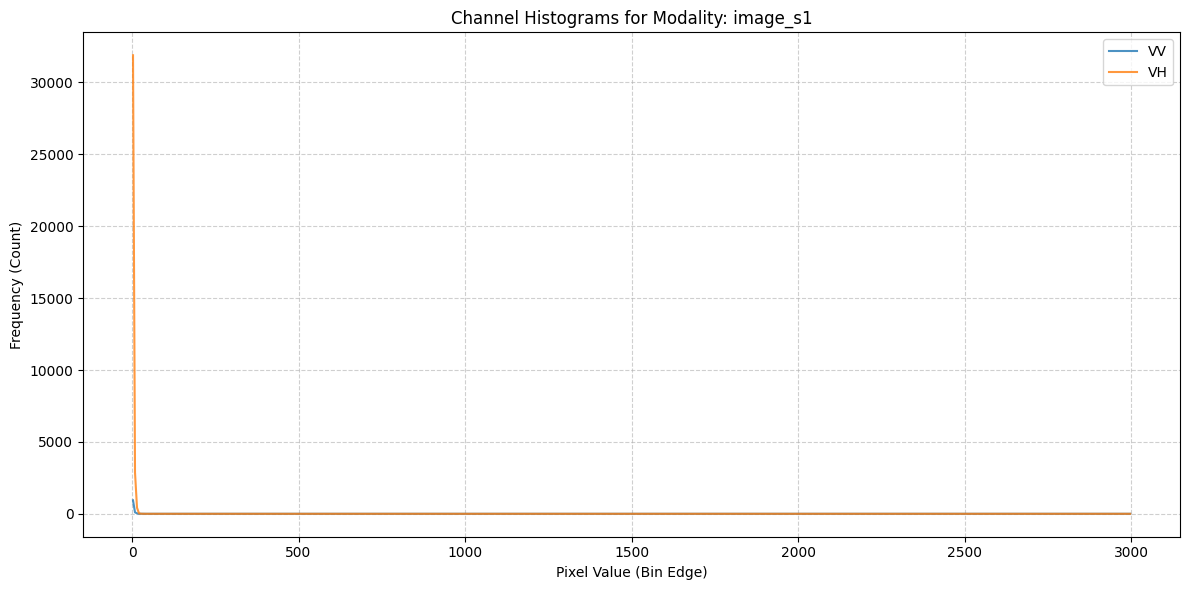

In [16]:
fig = plot_channel_histograms(
    "/home/nils/projects/GEO-Bench-2/geobench_v2/generate_benchmark/dataset_stats/benv2/benv2_stats.json"
)

S1 stats
mean 65520.461493055554
S1 statsstdS1 statsS1 stats 

mean5.196891751989473

 meanmean65450.72204861111min   
65252.7341319444466549665471.69545138889std


max stdstd 2148.360232246904  65534
4203.137891864774
1810.238361470782min

 min0min  
00max

 maxmax65535  
65535
65535
S1 stats
S1 statsmean
S1 stats mean
S1 stats65493.19954861111 
mean65519.141909722224
mean
  stdstd65515.2943055555665508.37486111111  

4.8032505449336581391.7333533697254
stdstd
 min min 2.788922777433548668.7092715392641 65503


0minmaxmin
   max65534654890 


maxmax  6551765535

65535
S1 statsS1 stats

meanmean  65522.439687565520.94173611111

std std4.384074862766802 
3.9326987182010824min
 minS1 statsS1 stats65502 


65502maxmeanmean
   65535max65503.37833333333465507.522569444445

 
std65533 std
 1091.8355057361487945.6160874466141

minmin  00

maxmax  6553565535

S1 stats
S1 statsmean
 mean65514.69888888889 
65508.87333333334std
 7.667995275377383S1 statsstd

 min mean945.6428691107442
65492 S1 st

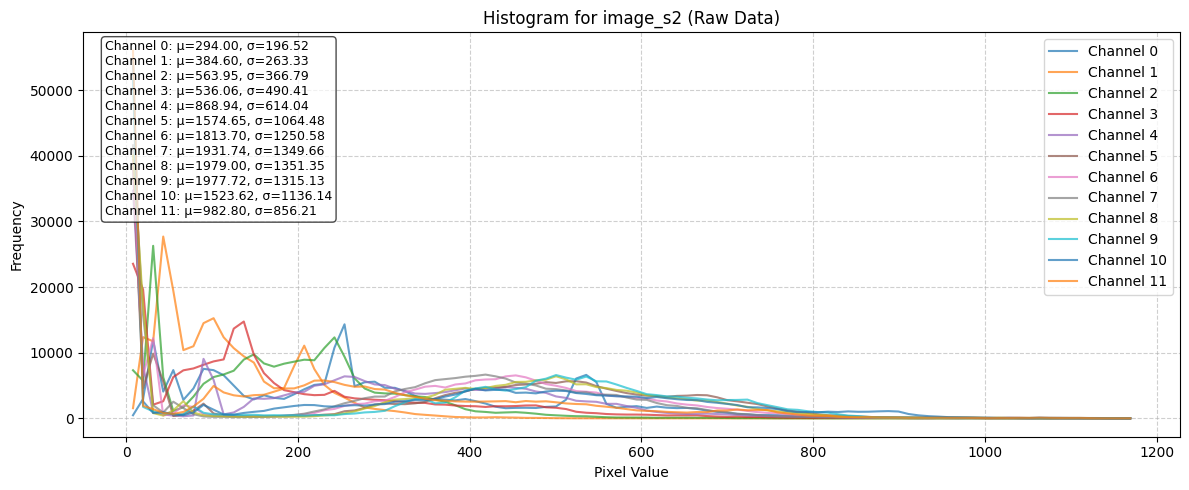

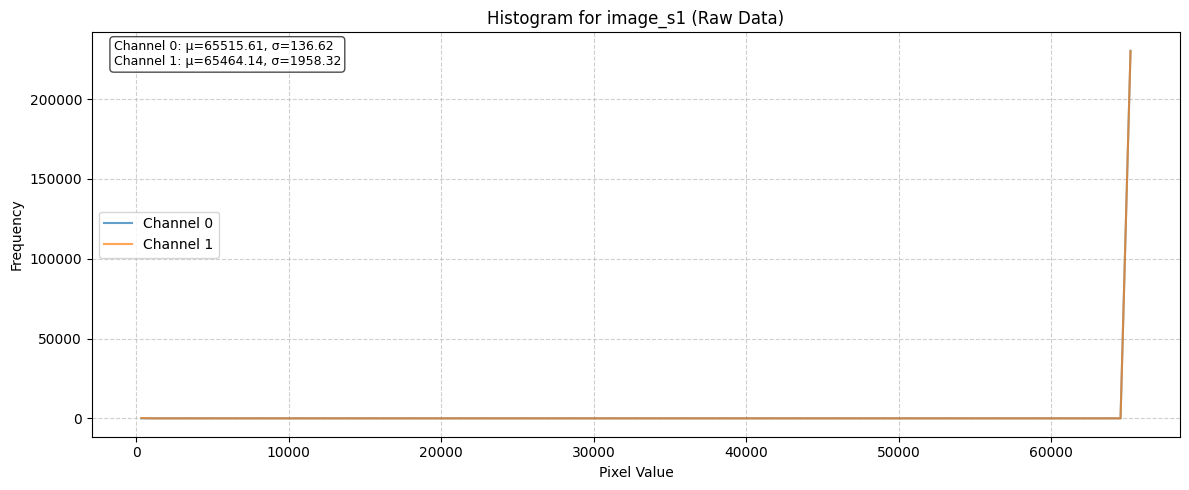

In [22]:
# Get a batch of data from the dataloader
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)

# Plot histograms for raw data
# Create a band_order without scaling factors for visualization
vis_band_order = {
    "s2": [b for b in band_order["s2"] if isinstance(b, str)],
    "s1": [b for b in band_order["s1"] if isinstance(b, str)],
}
raw_figs = plot_batch_histograms(
    raw_batch_stats, vis_band_order, title_suffix=" (Raw Data)"
)